<a href="https://colab.research.google.com/github/mactat/DL-IQIWA/blob/main/AutoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [218]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms
import random
from PIL import Image 
import copy

from torch import nn, Tensor
from torch.distributions import Distribution

from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
import torch.nn.functional as F

## Load Dataset ##

In [219]:

transform = transforms.Compose([
    transforms.ToTensor()
])

batch_size = 1

# Train
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_dataloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)

#Test
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_dataloader = DataLoader(testset, batch_size=batch_size, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


## Settings ##

In [220]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Model ##

In [221]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        c = capacity
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=4, stride=2, padding=1) # out: c x 16 x 16
        self.pool1 = nn.MaxPool2d((2, 2))
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=8, kernel_size=4, stride=2, padding=1) # out: c x 7 x 7
            
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))

        return x

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        c = capacity
        self.upSample = nn.Upsample(size=(2,2))
        self.conv1 = nn.ConvTranspose2d(in_channels=8, out_channels=16, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.ConvTranspose2d(in_channels=16, out_channels=3, kernel_size=4, stride=2, padding=1)
            
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = torch.sigmoid(self.conv2(x))
        # x = self.upSample(x)
        # x = torch.sigmoid(self.conv2(x))
        return x
    
class VariationalAutoencoder(nn.Module):
    def __init__(self):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


## Train ##


In [222]:
# Parameters for training
vae = VariationalAutoencoder()
vae = vae.to(device)

num_params = sum(p.numel() for p in vae.parameters() if p.requires_grad)
print('Number of parameters: %d' % num_params)

learning_rate = 1e-3
num_epochs = 3

optimizer = torch.optim.Adam(params=vae.parameters(), lr=learning_rate, weight_decay=1e-5)
criterion = nn.MSELoss()

Number of parameters: 5675


In [223]:
# Training loop

vae.train()

train_loss_avg = []

print('Training ...')
for epoch in range(num_epochs):
    train_loss_avg.append(0)
    num_batches = 0
    
    for image_batch, _ in train_dataloader:
        
        image_batch = image_batch.to(device)

        # vae reconstruction
        x = vae(image_batch)

        # reconstruction error
        loss = criterion(x, image_batch)
        
        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        
        # one step of the optmizer
        optimizer.step()
        
        train_loss_avg[-1] += loss.item()
        num_batches += 1
        
    train_loss_avg[-1] /= num_batches
    print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg[-1]))

Training ...
Epoch [1 / 3] average reconstruction error: 0.004134
Epoch [2 / 3] average reconstruction error: 0.002692
Epoch [3 / 3] average reconstruction error: 0.002438


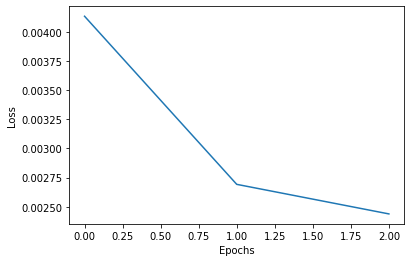

In [224]:
import matplotlib.pyplot as plt
plt.ion()

fig = plt.figure()
plt.plot(train_loss_avg)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

## Evaluation

In [225]:
vae.eval()

test_loss_avg, num_batches = 0, 0
for image_batch, _ in test_dataloader:
    
    with torch.no_grad():
    
        image_batch = image_batch.to(device)

        # vae reconstruction
        x = vae(image_batch)

        # reconstruction error
        loss = criterion(x, image_batch)

        test_loss_avg += loss.item()
        num_batches += 1
    
test_loss_avg /= num_batches
print('average reconstruction error: %f' % (test_loss_avg))

average reconstruction error: 0.002348


Original images


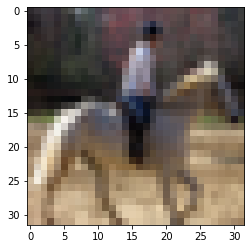

VAE reconstruction:


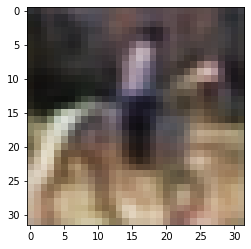

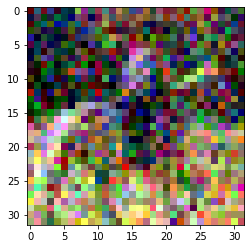

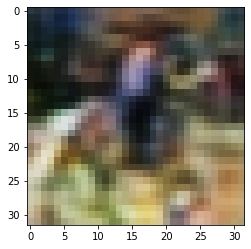

In [226]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

vae.eval()

def to_img(x):
    x = x.clamp(0, 1)
    return x

def show_image_tensor(img):
    img = torchvision.utils.make_grid(img,10,5)
    img = to_img(img)
    npimg = img.numpy()
    show_image_numpy(img)

def show_image_numpy(img):
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.show()

def visualise_output(images, model):

    with torch.no_grad():
    
        images = images.to(device)
        images = model(images)
        images = images.cpu()
        images = to_img(images)
        np_imagegrid = torchvision.utils.make_grid(images, 10, 5).numpy()
        plt.imshow(np.transpose(np_imagegrid, (1, 2, 0)))
        plt.show()

images, labels = iter(test_dataloader).next()

# First visualise the original images
print('Original images')
show_image_tensor(images)

# Reconstruct and visualise the images using the vae
print('VAE reconstruction:')
visualise_output(images, vae)

# noise
noise = np.random.normal(0, 0.2, images.numpy()[0].shape)
images = images + noise
show_image_tensor(images)

images = images.float()
visualise_output(images, vae)
